<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-Root" data-toc-modified-id="Set-Root-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set Root</a></span></li><li><span><a href="#Leer-YAML" data-toc-modified-id="Leer-YAML-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Leer YAML</a></span><ul class="toc-item"><li><span><a href="#Bibliotecas" data-toc-modified-id="Bibliotecas-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Bibliotecas</a></span></li></ul></li><li><span><a href="#Lectura-de-Datos" data-toc-modified-id="Lectura-de-Datos-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Lectura de Datos</a></span><ul class="toc-item"><li><span><a href="#Split-de-los-datos" data-toc-modified-id="Split-de-los-datos-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Split de los datos</a></span></li></ul></li><li><span><a href="#Consulta-de-API" data-toc-modified-id="Consulta-de-API-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Consulta de API</a></span></li><li><span><a href="#Definición-de-tipos-de-Variables" data-toc-modified-id="Definición-de-tipos-de-Variables-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Definición de tipos de Variables</a></span></li><li><span><a href="#Separación-de-Variables-según-tipo-de-datos" data-toc-modified-id="Separación-de-Variables-según-tipo-de-datos-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Separación de Variables según tipo de datos</a></span><ul class="toc-item"><li><span><a href="#Definición-de-Pipeline" data-toc-modified-id="Definición-de-Pipeline-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Definición de Pipeline</a></span></li><li><span><a href="#Reentrenamieto-de-modelos" data-toc-modified-id="Reentrenamieto-de-modelos-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Reentrenamieto de modelos</a></span></li></ul></li><li><span><a href="#Generación-de-Métricas-en-el-set-de-validacion" data-toc-modified-id="Generación-de-Métricas-en-el-set-de-validacion-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Generación de Métricas en el set de validacion</a></span><ul class="toc-item"><li><span><a href="#Matrices-de-Confusión" data-toc-modified-id="Matrices-de-Confusión-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Matrices de Confusión</a></span></li><li><span><a href="#Umbrales-con-recall-de-0.7" data-toc-modified-id="Umbrales-con-recall-de-0.7-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Umbrales con recall de 0.7</a></span></li><li><span><a href="#Métricas-sin-Umbral" data-toc-modified-id="Métricas-sin-Umbral-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Métricas sin Umbral</a></span></li></ul></li><li><span><a href="#Generación-de-predicciones-en-Test" data-toc-modified-id="Generación-de-predicciones-en-Test-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Generación de predicciones en Test</a></span></li><li><span><a href="#Exportaciones" data-toc-modified-id="Exportaciones-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Exportaciones</a></span><ul class="toc-item"><li><span><a href="#Exportación-de-resultados-de-Test" data-toc-modified-id="Exportación-de-resultados-de-Test-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Exportación de resultados de Test</a></span></li><li><span><a href="#Exportación-del-modelo" data-toc-modified-id="Exportación-del-modelo-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Exportación del modelo</a></span></li></ul></li><li><span><a href="#Shapley-Values" data-toc-modified-id="Shapley-Values-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Shapley Values</a></span></li></ul></div>

# Set Root

In [1]:
import os
import re

root = re.findall('.*predict_bad_rate', os.getcwd())[0]
os.chdir(root)

# Leer YAML

In [2]:
import yaml

with open('params.yaml', 'r') as file:
    yaml_config = yaml.safe_load(file)

## Bibliotecas

In [5]:
from copy import deepcopy
from importlib import reload
from shap import TreeExplainer
from plotly.offline import init_notebook_mode
from shap import summary_plot
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from time import time
from tqdm import tqdm 
from xgboost import XGBClassifier
import package.project.metrics.ks as ks_metrics
import package.project.viz.plot_functions as bna_plots
import joblib as jl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle as pickle
import plotly.graph_objects as go
import seaborn as sns
import sklearn.metrics as skm
import wandb
import warnings

init_notebook_mode(connected=True)
plt.rc('font', size=16)
sns.set_style('whitegrid')

# Lectura de Datos

In [6]:
X = pd.read_parquet(
    yaml_config['centralizado']['folder_processed'] + 
    'buro_centralizado_from_data_preparation_with_external_variables.parquet'
)
X.sort_values('fecha', inplace=True)

y = pd.read_parquet(
    yaml_config['centralizado']['folder_processed'] + 
    'maxima_mora_alcanzada_buro_centralizado_with_recent_bureau.parquet'
).squeeze()

y = y.loc[X.index]
y = y.ge(60).astype(int)

## Split de los datos

In [9]:
X_train_o, X_test, y_train_o, y_test = train_test_split(
    X, y, random_state=42, shuffle=False, test_size=0.2
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_o, y_train_o, random_state=42, shuffle=False, test_size=0.25
)

# Consulta de API


Consulta para saber los primeros 3 modelos para entrenarlos

In [10]:
api = wandb.Api()
entity = 'danipipe777'
project = 'project_ICESI_I'
sweep_id = 'pr80ried'

sweep = api.sweep(f'{entity}/{project}/{sweep_id}')

summary_list, config_list, name_list = [], [], []
for run in sweep.runs: 
    summary_list.append(run.summary._json_dict)

    config_list.append(
        {k: v for k,v in run.config.items()
         if (not k.startswith('_')) and (not pd.isnull(v))}
    )

    name_list.append(run.name)

    
config_df = pd.json_normalize(config_list)
config_df.index = name_list

summary_df = pd.json_normalize(summary_list)
summary_df.index = name_list
config_columns = config_df.columns

runs_df = summary_df.join(config_df)

best_models = (
    runs_df
    .sort_values(by='mean_average_precision_val', ascending=False)
    .head(3).index
)

# Definición de tipos de Variables

Variables que sean más del 50% nulas no serán consideradas inicialmente. También se definen qué variables son categóricas, ordinales y qué variables son numerical.

La única variable que no entra dentro de estas categorías es `fecha` fecha de consulta de buró de crédito.

In [11]:
porcetaje_de_nulidad = (
    X.isnull()
    .apply(lambda s: s.value_counts(True)).T
) 

porcetaje_de_nulidad.columns = ['not_null', 'null']
variables_muy_nulas = porcetaje_de_nulidad.query('null > 0.7').index

# Separación de Variables según tipo de datos

In [12]:
variables_categoricas_y_ordinales = [
    'riesgo_6', 'riesgo_12', 'ip', 'riesgo_12_bis',
    'peor_sit_bcra_ult', 'peor_sit_bureau_ult', 'sit_irregular'
]

X[variables_categoricas_y_ordinales] = \
    X[variables_categoricas_y_ordinales].astype('category')

ordinales = pd.Index(['ip'])
categoricas = X.select_dtypes('category').columns
categoricas = categoricas.delete(
    categoricas.isin(ordinales) |
    categoricas.isin(variables_muy_nulas)|
    categoricas.isin(['h3_id'])
)

numericas = X.select_dtypes('number').columns
numericas = numericas.delete(
    numericas.isin(variables_muy_nulas)
)

## Definición de Pipeline

In [13]:
config_ordinal = dict(
    handle_unknown='use_encoded_value',
    unknown_value=np.nan
)

config_onehot = dict(
    handle_unknown='ignore'
)

## Reentrenamieto de modelos

In [14]:
models = dict()
configs = runs_df[config_columns].to_dict(orient='index')
for model_name in tqdm(best_models):
    
    config_xgb = configs[model_name]
    xgb_preprocessing = ColumnTransformer([
        (
            'procesador_numericas',
            VarianceThreshold(config_xgb['variance_threshold']),
            numericas
        ),
        ('proccesador_ordinal', OrdinalEncoder(**config_ordinal), ordinales),
        ('procesador_categoricas', OneHotEncoder(**config_onehot), categoricas)
    ])
    
    xgb_pipeline = Pipeline([
        ('preprocesamiento', xgb_preprocessing),
        ('clasificador', XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            gamma=config_xgb['gamma'],
            learning_rate=config_xgb['learning_rate'],
            max_depth=config_xgb['max_depth'],
            min_child_weight=config_xgb['min_child_weight'],
            n_estimators=config_xgb['n_estimators'],
            reg_alpha=config_xgb['reg_alpha'],
            reg_lambda=config_xgb['reg_lambda'],
            random_state=10
        ))
    ])
    
    models[model_name] = xgb_pipeline
    models[model_name].fit(X_train, y_train)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]C:\Users\danie\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

 33%|████████████████████████████                                                        | 1/3 [00:13<00:27, 13.86s/it]C:\Users\danie\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:26<00:13, 13.31s/it]C:\Users\danie\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:39<00:00, 13.32s/it]


# Generación de Métricas en el set de validacion

In [15]:
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

ths = np.linspace(0, 1, 1000)
metricas_en_validacion = dict()
for model_name, model in tqdm(models.items()):
    accuracies_val, recalls_val = [], []
    precisions_val, f1s_val = [], []
    matrices_confusion_val = []
    
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    y_pred_proba_val = model.predict_proba(X_val)[:, 1]
    
    # Métricas independientes de umbral
    roc_auc_score_train = skm.roc_auc_score(y_train, y_pred_proba_train)
    average_precision_score_train = skm.average_precision_score(y_train, y_pred_proba_train)
    
    roc_auc_score_val = skm.roc_auc_score(y_val, y_pred_proba_val)
    average_precision_score_val = skm.average_precision_score(y_val, y_pred_proba_val)
    df_KS_train = ks_metrics.decile_metrics(y_train, y_pred_proba_train)
    df_KS_val = ks_metrics.decile_metrics_test_from_train(
        df_KS_train, y_val, y_pred_proba_val
    )
    
    # Métricas dependientes de umbral
    for th in ths:
        accuracies_val.append(skm.accuracy_score(y_val, y_pred_proba_val > th))
        recalls_val.append(skm.recall_score(y_val, y_pred_proba_val > th))
        precisions_val.append(skm.precision_score(y_val, y_pred_proba_val > th))
        f1s_val.append(skm.f1_score(y_val, y_pred_proba_val > th))
        matrices_confusion_val.append(skm.confusion_matrix(y_val, y_pred_proba_val > th))
        
    metricas_en_validacion[model_name] = dict(
        roc_auc_score_train=roc_auc_score_train,
        average_precision_score_train=average_precision_score_train,
        roc_auc_score_val=roc_auc_score_val,
        average_precision_score_val=average_precision_score_val,
        max_KS_train=df_KS_train.KS.max(),
        max_KS_val=df_KS_val.KS.max(),
        accuracies_val=accuracies_val,
        recalls_val=recalls_val,
        precisions_val=precisions_val,
        f1s_val=f1s_val,
        matrices_confusion_val=matrices_confusion_val,
        df_KS_train=df_KS_train,
        df_KS_val=df_KS_val,
        umbrales=ths
    )

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:34<00:00, 11.44s/it]


In [16]:
metricas_sin_umbral =[
    'roc_auc_score_train', 'average_precision_score_train',
    'roc_auc_score_val', 'average_precision_score_val',
    'max_KS_train', 'max_KS_val', 
]

metricas_con_umbral =[
    'accuracies_val', 'recalls_val', 'precisions_val',
    'f1s_val', 'matrices_confusion_val', 'umbrales'
]

df_metricas = pd.DataFrame.from_dict(
    metricas_en_validacion, orient='index'
)

df_metricas_sin_umbral = df_metricas[metricas_sin_umbral]
df_metricas_con_umbral = df_metricas[metricas_con_umbral]

## Matrices de Confusión

In [17]:
reload(bna_plots)
get_best_index = lambda f1s: np.argmax(f1s)

figuras_matrices = {
    k: bna_plots.plot_confusion_matrix(
        v.matrices_confusion_val, k, ths, get_best_index(v.f1s_val),
        0, 300
    )
    for k, v in df_metricas_con_umbral.iterrows()
}

for k, v in figuras_matrices.items():
    v.show()

C:\Users\danie\Clases\ICESI\Proyecto_GE_I\package\project\viz\plot_functions.py:62: RuntimeWarning:

invalid value encountered in longlong_scalars



## Umbrales con recall de 0.7

  1. sleek-sweep-99: `0.0541`
  2. skilled-sweep-20: `0.0490`
  3. ruby-sweep-87: `0.0501`

## Métricas sin Umbral

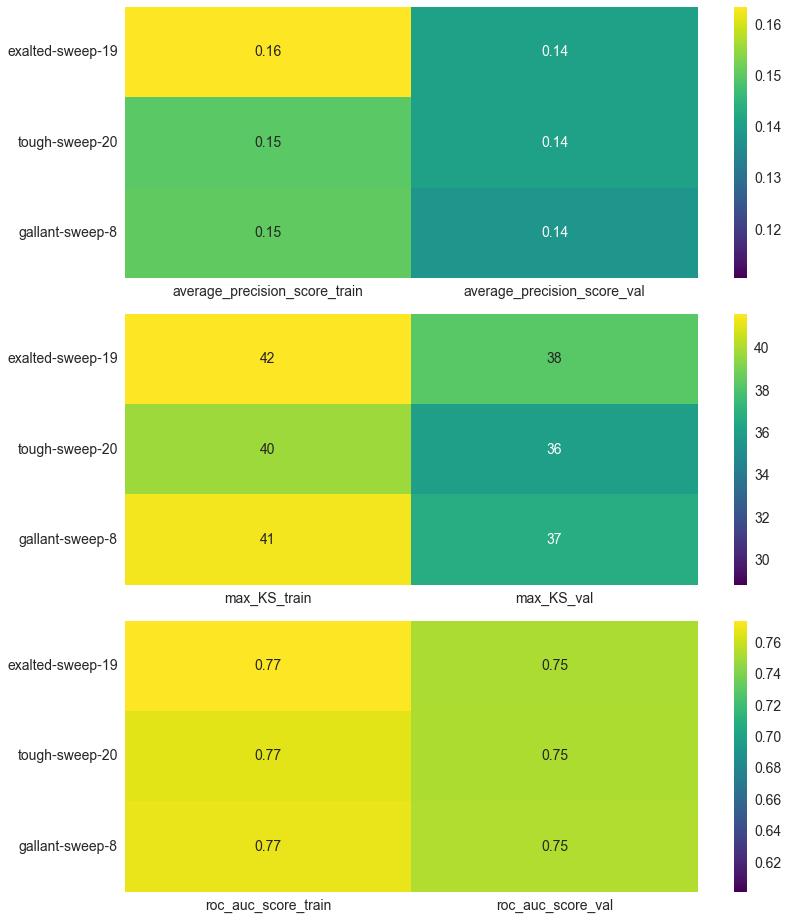

In [17]:
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

fig, axs = plt.subplots(3, 1, figsize=(12, 13), sharey=True)
axs = axs.flatten()

df_metricas_sin_umbral = df_metricas_sin_umbral[
    df_metricas_sin_umbral.columns.sort_values()
]

for i, ax in enumerate(axs):
    start, end = i*2, i*2+2
    sns.heatmap(
        df_metricas_sin_umbral.iloc[:, start:end],
        ax=ax,
        vmin=df_metricas_sin_umbral.iloc[:, start:end].min().min()*0.8,
        vmax=df_metricas_sin_umbral.iloc[:, start:end].max().max(),
        annot=True,
        cmap='viridis'
    )
    
fig.tight_layout()

# Generación de predicciones en Test

Los tres modelos están muy parecidos, entonces se usa skilled-sweep-20 solo porque tiene un TP adicional a los demás modelos

In [1]:
modelo_seleccionado = deepcopy(models['exalted-sweep-19'])
modelo_seleccionado.fit(X_train_o, y_train_o)

test_probas = modelo_seleccionado.predict_proba(X_test)[:, 1]
test_preds = test_probas > 0.0511

test_confusion_matrix = skm.confusion_matrix(y_test, test_preds)

def get_bad_rate(N): return N[1, 0]/(N[0, 0] + N[1, 0])
def get_tasa_aprobados(N): return N[0, 0]/(N[0, 0] + N[0, 1])

print('Bad Rate Test: ', get_bad_rate(test_confusion_matrix))
print('Baseline:', y_test.value_counts(True).loc[1])
print('Tasa de preaprobados', get_tasa_aprobados(test_confusion_matrix))
print()
print('Matrix Confusion', test_confusion_matrix, sep='\n')

NameError: name 'deepcopy' is not defined

# Exportaciones
## Exportación de resultados de Test

In [122]:
(
    y_test
    .to_frame(name='y_true')
    .assign(y_pred_proba=test_probas, y_pred=test_preds.astype(int))
    .to_parquet(
        yaml_config['centralizado']['folder_processed'] + 
        'predicciones_centralizado_exalted-sweep-19.parquet'
    )
)

## Exportación del modelo

In [123]:
model_name = 'exalted-sweep-19'
jl.dump(
    models[model_name],
    yaml_config['folder_models'] +
    f'../models/pre-seleccionados/{model_name}.joblib'
)

['../models/pre-seleccionados/exalted-sweep-19.joblib']

# Shapley Values

In [20]:
one_hot_encoder_categories = (
    models[model_name].named_steps['preprocesamiento']
    .transformers_[2][1]
).categories_

post_processing_columns_categorical = list()
for i, cat_name in enumerate(categoricas):
    post_processing_columns_categorical += [
        cat_name + f'_{cat}' for cat in one_hot_encoder_categories[i]
    ]

## Numericas
variance_transformer = (
    models[model_name].named_steps['preprocesamiento']
    .transformers_[0][1]
)

variance_filter = variance_transformer.variances_ > variance_transformer.threshold
numericas_list = numericas[variance_filter].to_list()
for i in range(36, len(numericas_list)):
    numericas_list[i] = f'external_variable_{i}'
    
columnas_post = \
    numericas_list + \
    ordinales.to_list() + \
    post_processing_columns_categorical

In [129]:
xgb_pipeline = jl.load(
    yaml_config['folder_models'] +
    'pre-seleccionados/ruby-sweep-87.joblib'
)

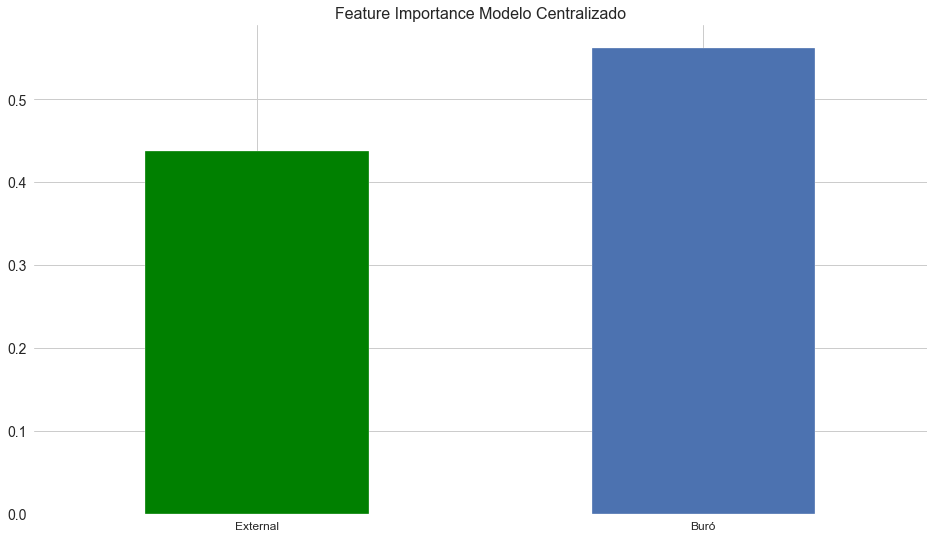

In [134]:
importance_features = xgb_pipeline.named_steps['classificador'].feature_importances_

fig, ax = plt.subplots(figsize=(16, 9))

df_importances = pd.Series(
    importance_features,
    index=columnas_post,
    name='importances'
)
df_importances.sort_values(ascending=True, inplace=True)
# index = df_importances.index.str.contains('external')

importances_agregated = df_importances.groupby(
    df_importances.index.str.contains('external')
).sum()
importances_agregated.sort_index(
    inplace=True, ascending=False
)

ax = importances_agregated.plot.bar(rot=0)
xlabel = ax.get_xticklabels()
ax.set_xticklabels(xlabel, fontsize=12)

index = importances_agregated.index

for i, patch in enumerate(ax.patches):
    if (index[i]):
        patch.set_facecolor('green')

xticks = ax.get_xticks()
ax.set_xticks(xticks, labels=index.map({True:'External', False:'Buró'}))

ax.set_title('Feature Importance Modelo Centralizado', fontsize=16)
plt.savefig(
    yaml_config['reports'] +
    'feature_importance_centralizado.png', dpi=300
)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


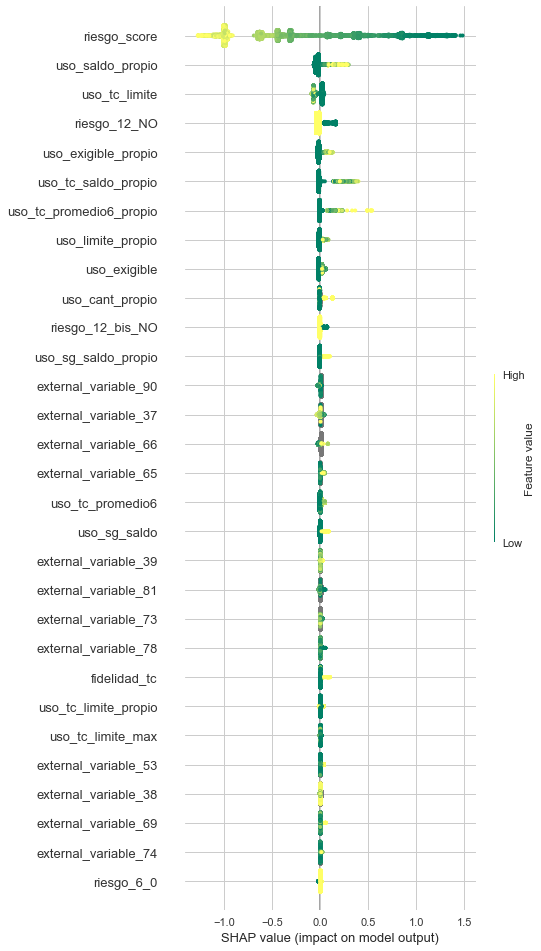

In [33]:
model = models[model_name].named_steps['classificador']
explainer = TreeExplainer(model, feature_names=columnas_post)
shap_values = explainer.shap_values(
    models[model_name].named_steps['preprocesamiento'].transform(X_test)
)

summary_plot(
    shap_values,
    models[model_name].named_steps['preprocesamiento'].transform(X_test),
    feature_names=columnas_post,
    max_display=30,
    cmap=plt.get_cmap('summer'),
    show=False
)
plt.tight_layout()

plt.savefig(
    yaml_config['reports'] +
    'shap_values_modelo_centralizado.png', dpi=400
)